In [1]:
# -------------------------------------------------------------------------------------------------------------------- #
# external imports
# ----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from matplotlib.ticker import FuncFormatter



# Travel Demand Model

### Load data
Reading the data and filtering to only include Munich travel data (any other city code works as well)

In [2]:
# Specify path for B2_Regional-Datensatzpaket\\CSV\\MiD2017_Regional_Wege.csv 
# path = 

# Read csv file
df = pd.read_csv(path, sep=';', decimal=',',  index_col=0)

# Filter dataframe to only include Munich travel data                                                               -> 48627 entries
# The study was conducted over 2016 and 2017 so all data is relevant especially because else the extrapolation factor would be wrong
df_mun = df[(df['VBGEM'] == 91620000)]



### Cleaning of data
We clean the Munich data by excluding hvm values that are not relevant. (everything except MIT and PT) Further, we drop all rows that don't list the mode of transport. Additionally, we exclude long paths >= 100km as these trips most likely are not done in the boundaries of the city. Finally, we map all hvm values of 4 to 3 as with SAEVs you are never driving by yourself.

In [3]:
# Include only city traffic and therefore take out LKW (17+18), Schiff/Fähre (19), Fernzug (20), Fernlinienbus (21), Reisebus (22), Flugzeug (23), andere (24) ('hvm_diff2' column equals) [position 71 in codebook]                                   -> 47905 entries
df_mun_clean = df_mun[~df_mun['hvm_diff2'].isin(range(17, 25))]

# Drop rows where hvm equals 1, 2 and 9(Zu Fuß, Fahrrad, keine Angabe)                                              -> 28323 entries
df_mun_clean = df_mun_clean[~df_mun_clean['hvm'].isin([1, 2, 9])] # hvm = 9 = 106 entries

# Drop rows where hvm equals 703 (Weg ohne Detail) as we cant use this data                                         -> 25774 entries
df_mun_clean = df_mun_clean[~df_mun_clean['hvm'].isin([703])] # hvm = 703 = 2549 entries                                                   

# Exclude long paths >= 100km, using wegkm_imp here as we would underestimate otherwise                             -> 25090 entries
df_mun_clean = df_mun_clean[(df_mun_clean['wegkm_imp'] < 100)]

# Replace values where hvm is 4 with 3 (3 = Mitfahrer)
df_mun_clean.loc[df_mun_clean['hvm'] == 4, 'hvm'] = 3

# Build smaller df with only selected columns [position 5, 6, 10, 11, 12, 13, 14, 16, 17, 21, 41, 42, 44, 69, 71 in codebook]
selected_columns = ["W_GEW","W_HOCH","ST_MONAT", "ST_JAHR", "ST_WOTAG", "ST_WOCHE", "arbwo", "feiertag", "saison", "W_SZ", "zweck_mop", "wegkm", "wegkm_imp", "hvm", "hvm_diff2"]
df_mun_clean = df_mun_clean[selected_columns]

### Cleaning of data 2
We drop all rows that don't have a starting time as these rows are unusable for our analysis. We change the index to datetime, round 'W_SZ' to 30min and sort the data by 'ST_WOTAG', 'W_SZ' and 'wegkm_imp' to prepare for further processing.

In [4]:
# Replace blanks with NaN values
df_mun_sort = df_mun_clean.replace(' ', np.nan)

# Drop rows with NaN values in 'W_SZ' column                                                                        -> 23336 entries
df_mun_sort.dropna(subset=['W_SZ'], inplace=True)
# Maybe we have to use a factor here to not underestimate the wegkm as we only use data with starting time and drop 1754 rows which is 3,61% of the original Munich data 

# Convert 'W_SZ' column to datetime with time only
df_mun_sort['W_SZ'] = pd.to_datetime(df_mun_sort['W_SZ'], format='%H:%M:%S', errors='coerce')

# Drop rows with NaT values in 'W_SZ' column
df_mun_sort = df_mun_sort.dropna(subset=['W_SZ'])

# Round 'W_SZ' to nearest 60 minutes -> Why change back to string?
df_mun_sort['W_SZ'] = df_mun_sort['W_SZ'].dt.floor('60min')#.dt.strftime('%H:%M:%S')

# Sort df by datetime in 'W_SZ' column
df_mun_sort = df_mun_sort.sort_values(by=["ST_WOTAG", 'W_SZ', 'wegkm_imp'])

# Reorder columns
new_column_order = ["ST_WOCHE", "ST_WOTAG", "W_SZ", "wegkm_imp", "wegkm", "ST_MONAT", "ST_JAHR", "W_GEW","W_HOCH", "feiertag", "saison", "zweck_mop", "hvm", "hvm_diff2", "arbwo"]
df_mun_sort = df_mun_sort[new_column_order]



### Compensation Factor

#### First Compensation Factor
Calculating first compensation factor (factor_9_703_hoch) to counteract underestimation of wegkm_imp_hoch after eliminating data without mode of transport (hvm = 9, 703). We assume that the distribution of mode of transport for hvm = 9, 703 is the same as in the data with mode of transport. (we use wegkm_imp_hoch for calculation)

In [5]:
### Preparation of the data for the calculation of factor_9_703_hoch
selected_columns = ["W_HOCH","hvm", "hvm_diff2", "ST_MONAT", "ST_JAHR", "ST_WOTAG", "ST_WOCHE", "W_SZ", "wegkm", "wegkm_imp", "saison", "arbwo", "feiertag", "zweck_mop"]
df_mun_factor_9_703 = df_mun[selected_columns].copy()

# Replace values where hvm is 4 with 3
df_mun_factor_9_703.loc[df_mun_factor_9_703['hvm'] == 4, 'hvm'] = 3

df_mun_factor_9_703 = df_mun_factor_9_703[(df_mun_factor_9_703['wegkm_imp'] < 100)]

df_mun_factor_9_703 = df_mun_factor_9_703[~df_mun_factor_9_703['hvm_diff2'].isin(range(17, 25))]

# Calculate wegkm_imp_hoch 
df_mun_factor_9_703['wegkm_imp_hoch'] = df_mun_factor_9_703['W_HOCH'] * df_mun_factor_9_703['wegkm_imp']

# Calculate sum of wegkm_imp_hoch for all hvm values and store them in a new DataFrame
df_hvm_sums = df_mun_factor_9_703.groupby('hvm')['wegkm_imp_hoch'].sum().reset_index(name='sum_hvm_wegkm')

# Calculate sum of wegkm_imp_hoch for 9 and 703
sum_hvm_9_703 = df_hvm_sums[df_hvm_sums['hvm'].isin([9,703])]['sum_hvm_wegkm'].sum()

# Sum the sums of 1,2,3,5 and divide each sum by the total sum
sum_hvm_1_2_3_5 = df_hvm_sums[df_hvm_sums['hvm'].isin([1, 2, 3, 5])]['sum_hvm_wegkm'].sum()
df_hvm_sums['share'] = df_hvm_sums[df_hvm_sums['hvm'].isin([1, 2, 3, 5])]['sum_hvm_wegkm'] / sum_hvm_1_2_3_5

# Calculation of lost kilometers that are attributable to hvm = 3 and hvm = 5 respectively
lost_wegkm_3 = np.ceil(sum_hvm_9_703 * df_hvm_sums[df_hvm_sums['hvm'] == 3]['share'].values[0])
lost_wegkm_5 = np.ceil(sum_hvm_9_703 * df_hvm_sums[df_hvm_sums['hvm'] == 5]['share'].values[0])
lost_wegkm_3_5 = lost_wegkm_3 + lost_wegkm_5

# Calculate the compensation factor for hvm 3 and 5 combined
sum_hvm_3_5 = df_hvm_sums[df_hvm_sums['hvm'].isin([3, 5])]['sum_hvm_wegkm'].sum()

# We only have one compensation factor because we don't know the split between hvm = 3 and hvm = 5
factor_9_703_hoch = (lost_wegkm_3_5 + sum_hvm_3_5) / sum_hvm_3_5


We're losing roughly 3 million kms by filtering out hvm 9 and 703. To not underestimate total wegkm we must include a compensation factor to adjust our result.

We can adjust our wegkm_imp_hoch by calculating the share of km for each hvm. Next, we multiply the share with the lost kms. The result is then added to the total wegkm_imp_hoch and divided by the total wegkm_imp_hoch to get a compensation factor.

A compensation factor of 1.07 means that we would add 7% km to all wegkm_imp_hoch values to account for lost kms.

#### Second and third compensation factor
Calculating second and third compensation factor for hvm = 3 (factor_3_no_SZ_hoch) and hvm = 5 (factor_5_no_SZ_hoch) to counteract underestimation of wegkm_imp_hoch after eliminating data without a starting time. (using wegkm_imp_hoch for calculation)

In [7]:
# Drop rows where hvm equals 1, 2 and 9(Zu Fuß, Fahrrad, keine Angabe)                                              -> 28323 entries
df_mun_factor_no_SZ = df_mun_factor_9_703[~df_mun_factor_9_703['hvm'].isin([1, 2, 9])] # hvm = 9 = 106 entries

# Drop rows where hvm equals 703 (Weg ohne Detail) as we cant use this data                                         -> 25774 entries
df_mun_factor_no_SZ = df_mun_factor_no_SZ[~df_mun_factor_no_SZ['hvm'].isin([703])] # hvm = 703 = 2549 entries

# Replace blanks with NaN values
df_mun_factor_no_SZ = df_mun_factor_no_SZ.replace(' ', np.nan)

# Filter by 'W_SZ' column and only include rows where 'W_SZ' is NaN
df_mun_only_no_SZ = df_mun_factor_no_SZ[df_mun_factor_no_SZ['W_SZ'].isna()]

# Sum of wegkm_imp_hoch in df_mun_only_no_SZ (sum of wegkm for all rows without a starting time)
sum_wegkm_imp_hoch_no_SZ = df_mun_only_no_SZ['wegkm_imp_hoch'].sum()

# Sum of wegkm_imp_hoch in df_mun_only_no_SZ for hvm = 3 and hvm = 5 (sum of wegkm for all rows without a starting time split in hvm = 3 and hvm = 5)
sum_wegkm_imp_hoch_no_SZ_3 = df_mun_only_no_SZ[df_mun_only_no_SZ['hvm'] == 3]['wegkm_imp_hoch'].sum()
sum_wegkm_imp_hoch_no_SZ_5 = df_mun_only_no_SZ[df_mun_only_no_SZ['hvm'] == 5]['wegkm_imp_hoch'].sum()


# Calculating sum of wegkm_imp_hoch for df_mun_factor_no_SZ for hvm = 3 and hvm = 5 (sum of wegkm for all rows including those without a starting time for hvm = 3 and hvm = 5)
sum_wegkm_imp_hoch_3 = df_mun_factor_no_SZ[df_mun_factor_no_SZ['hvm'] == 3]['wegkm_imp_hoch'].sum()
sum_wegkm_imp_hoch_5 = df_mun_factor_no_SZ[df_mun_factor_no_SZ['hvm'] == 5]['wegkm_imp_hoch'].sum()

# Calculating the compensation factor for hvm = 3 and hvm = 5 for no 'W_SZ' values (how many wegkm are lost in relative terms by missing starting times for hvm = 3 and hvm = 5)
factor_3_no_SZ_hoch =  sum_wegkm_imp_hoch_3 / (sum_wegkm_imp_hoch_3 - sum_wegkm_imp_hoch_no_SZ_3)
factor_5_no_SZ_hoch = sum_wegkm_imp_hoch_5 / (sum_wegkm_imp_hoch_5 - sum_wegkm_imp_hoch_no_SZ_5)


For both 9_703_factor and no_SZ_factors using the wegkm_imp_hoch values for their calculation leads to higher values. This can help to counteract the underestimation of the total wegkm_imp_hoch. Furthermore, the user manual on page 33 states that the distribution after using W_HOCH is to be used to assign all other missing values. See percentages in table 5.

#### Inclusion of compensation factors
We include factor_9_703_hoch, factor_3_no_SZ_hoch, factor_5_no_SZ_hoch in df_mun_sort

In [8]:
# Create a new column for factor_9_703_hoch
df_mun_sort['factor_9_703_hoch'] = factor_9_703_hoch

# Create a new column for factor_3_no_SZ_hoch and factor_5_no_SZ_hoch
df_mun_sort['factor_no_SZ_hoch'] = np.nan

# Apply factor_3_no_SZ_hoch for entries where hvm == 3
df_mun_sort.loc[df_mun_sort['hvm'] == 3, 'factor_no_SZ_hoch'] = factor_3_no_SZ_hoch

# Apply factor_5_no_SZ_hoch for entries where hvm == 5
df_mun_sort.loc[df_mun_sort['hvm'] == 5, 'factor_no_SZ_hoch'] = factor_5_no_SZ_hoch

#### Extrapolation of wegkm
Next we calculate 'wegkm_imp_hoch' (wegkm extrapolated for the total munich population) by multiplying 'wegkm_imp' with the provided extrapolation factor 'W_HOCH' and the three compensation factors.

In [9]:
# Add a new column 'wegkm_imp_hoch' which is the product of 'W_HOCH' and 'wegkm_imp'
# Rounding up to lessen the effect of underestimation
df_mun_sort['wegkm_imp_hoch'] = np.ceil(df_mun_sort['W_HOCH'] * df_mun_sort['factor_9_703_hoch'] * df_mun_sort['factor_no_SZ_hoch']) * df_mun_sort['wegkm_imp']

# Specify the new column order
new_column_order = ["ST_WOCHE", "ST_WOTAG", "W_SZ", "W_GEW","W_HOCH", "wegkm_imp_hoch",  "wegkm_imp", "wegkm", "ST_MONAT", "ST_JAHR", "feiertag", "saison", "zweck_mop", "hvm", "hvm_diff2", "arbwo", "factor_9_703_hoch", "factor_no_SZ_hoch"]

# Reassign the DataFrame to the new column order
df_mun_sort = df_mun_sort[new_column_order]

#### Scaling of extrapolation factors
As the extrapolation factors are calculated for one sample day, we have to multiply the wegkm_imp_hoch by 7 because we split the data into 7 days and therefore roughly only have 1/7 of total wegkm per day. Below, three different approaches are discussed.

Some comments on the extrapolation factor W_HOCH (siehe Nutzerhandbuch MiD2017, S. 31ff und Methodenhandbuch MiD2017, S. 47ff):
1. Using W_HOCH gives the estimated number of journeys made by the German resident population on an average day in Germany.
2. W_HOCH already includes W_GEW, so we don't have to multiply it with W_GEW.
3. W_GEW accounts for differing probability of being selected for the survey. It also aligns the distribution of relevant characteristics with the population. For example, small households are systematically underrepresented in the study. W_GEW corrects this bias.
4. W_GEW was calibrated on Federal state, employment or predominant livelihood, school-leaving qualification, primary school area, gender and age group.
5. A compensation factor is included in W_HOCH which accounts for people that were mobile but did not report on their trips. It also accounts for people that reported more than 8/12 trips, after which they were not recorded in detail.
6. When evaluating characteristics with many missing values or when analyzing very specific groups with small case numbers (for example, 80+ year olds with a driving license in a multi-person household in a rural area), the influence of weight should be analyzed by comparing weighted and unweighted values before interpreting the results. -> It is not clear if we have to do this comparison for the Munich data as it still seems to be big and includes many different groups.
7. The following should be noted when extrapolating to total values: Many MiD-variables have missing values (missings). For the correct determination of extrapolated values, it is often necessary to include some of these missing values in the extrapolation. See explanation on page 33 of the user manual. 

#### Calculate weekly km
Multiplying all wegkm_imp_hoch values by 7 to account for the split into 7 days

In [10]:
# Create 'wegkm_imp_hoch_fac' column -> Multiply all wegkm_imp_hoch values by 7 to account for the split into 7 days
df_mun_sort['wegkm_imp_hoch_fac'] = df_mun_sort['wegkm_imp_hoch'] * 7

# Specify the new column order
new_column_order = ["ST_WOCHE", "ST_WOTAG","W_SZ", "W_GEW","W_HOCH", "wegkm_imp_hoch", "wegkm_imp_hoch_fac",  "wegkm_imp", "wegkm",  "ST_MONAT", "ST_JAHR", "feiertag", "saison", "zweck_mop", "hvm", "hvm_diff2", "arbwo", "factor_9_703_hoch", "factor_no_SZ_hoch"]

# Reassign the DataFrame to the new column order
df_mun_sort = df_mun_sort[new_column_order]

In [11]:
# Group by 'ST_WOTAG' and calculate the sum for 'wegkm_imp_hoch_fac'
total_wegkm_day = df_mun_sort.groupby('ST_WOTAG')['wegkm_imp_hoch_fac'].sum().reset_index()

# Rename the columns for better clarity
total_wegkm_day.columns = ['Day of Week', 'Total wegkm_imp_hoch_fac']

# Optionally, map numeric days to weekday names
weekday_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
total_wegkm_day['Day of Week'] = total_wegkm_day['Day of Week'].map(weekday_names)


### Exponential smoothing of data
Applying Holt-Winters Exponential Smoothing to the dataset before aggregation and saving aggregated data of plots in dictionary with dfs for each day. (dfs_tot_MIT_PT_nohw_hw)

In [12]:
# Mapping dictionary for hvm labels
hvm_labels = {
    3: "MIV",
    5: "ÖPNV",
}

# Mapping dictionary for ST_WOTAG to weekday names
weekday_names = {
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday",
    7: "Sunday"
}
# Dictionary to store DataFrames for each day
dfs_tot_MIT_PT_nohw_hw = {}

# Function to smooth and aggregate data
def smooth_and_aggregate(group, col, periods):
    model = ExponentialSmoothing(
        group[col],
        seasonal='add',
        seasonal_periods=periods
    )
    fitted_model = model.fit(optimized=True)
    group[f'HW_{col}'] = fitted_model.fittedvalues
    aggregated_smoothed = group.groupby('W_SZ')[f'HW_{col}'].sum().reset_index()
    aggregated_original = group.groupby('W_SZ')[col].sum().reset_index()
    return aggregated_smoothed, aggregated_original

# Group by 'ST_WOTAG' and apply the smoothing function
for name, group in df_mun_sort.groupby('ST_WOTAG'):
    #plt.figure(figsize=(20, 6))
    periods = 7

    # Aggregate original and smoothed 'wegkm_imp_hoch_fac' data
    aggregated_smoothed, aggregated_group = smooth_and_aggregate(group.copy(), 'wegkm_imp_hoch_fac', periods)

    # Combine aggregated and smoothed data into one DataFrame
    combined_df = pd.merge(aggregated_group, aggregated_smoothed, on='W_SZ')

    # Aggregate original and smoothed 'MIV' data if available
    miv_group = group[group['hvm'] == 3].copy()  # Prevent SettingWithCopyWarning
    if not miv_group.empty:
        miv_smoothed, miv_original = smooth_and_aggregate(miv_group, 'wegkm_imp_hoch_fac', periods)
        combined_df = pd.merge(combined_df, miv_original, on='W_SZ', how='left', suffixes=('', '_MIV'))
        combined_df = pd.merge(combined_df, miv_smoothed, on='W_SZ', how='left', suffixes=('', '_MIV'))

    # Aggregate original and smoothed 'MIV' data if available
    pt_group = group[group['hvm'] == 5].copy()  # Prevent SettingWithCopyWarning
    if not pt_group.empty:
        pt_smoothed, pt_original = smooth_and_aggregate(pt_group, 'wegkm_imp_hoch_fac', periods)
        combined_df = pd.merge(combined_df, pt_original, on='W_SZ', how='left', suffixes=('', '_PT'))
        combined_df = pd.merge(combined_df, pt_smoothed, on='W_SZ', how='left', suffixes=('', '_PT'))

    # Store the combined DataFrame in the dictionary
    day_name = weekday_names.get(name, "Unknown")
    dfs_tot_MIT_PT_nohw_hw[day_name] = combined_df



C:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Opti

### Interpolation of values
Interpolating values.

In [13]:
# Copying dictionary to avoid overwriting the original data
dfs_interpolated = dfs_tot_MIT_PT_nohw_hw.copy()

# Create a full time index by including missing times and reindexing, and fill missing values with NaN
full_time_index = pd.date_range(start='1900-01-01 00:00:00', end='1900-01-01 23:00:00', freq='60T')
for day, df in dfs_interpolated.items():
    dfs_interpolated[day] = df.set_index('W_SZ').reindex(full_time_index)
    
# Interpolate missing values with method='time' in dfs_interpolated for all days
for day, df in dfs_interpolated.items():
    dfs_interpolated[day] = df.interpolate(method='time')

# ONLY NEEDED FOR 30 MINUTE INTERVALS: Manually calculate the missing value on Monday at 00:00:00 for MIV (idea of wrap around time interpolation)
# dfs_interpolated['Monday'].iloc[0]['wegkm_imp_hoch_fac_HW_MIV'] = (dfs_interpolated['Monday'].iloc[1]['wegkm_imp_hoch_fac_HW_MIV'] + dfs_interpolated['Monday'].iloc[-1]['wegkm_imp_hoch_fac_HW_MIV']) / 2
# Manually calculate the missing value on Wednesday at 00:00:00 for PT
# dfs_interpolated['Wednesday'].iloc[0]['wegkm_imp_hoch_fac_HW_PT'] = (dfs_interpolated['Wednesday'].iloc[1]['wegkm_imp_hoch_fac_HW_PT'] + dfs_interpolated['Wednesday'].iloc[-1]['wegkm_imp_hoch_fac_HW_PT']) / 2

In [14]:
# Copying dictionary to avoid overwriting the original data
dfs_interpolated = dfs_tot_MIT_PT_nohw_hw.copy()

# Create a full time index by including missing times and reindexing, and fill missing values with NaN
full_time_index = pd.date_range(start='1900-01-01 00:00:00', end='1900-01-01 23:00:00', freq='60T')

for day, df in dfs_interpolated.items():
    # Reindex to include missing times
    df = df.set_index('W_SZ').reindex(full_time_index)
    
    # Replace all NaN values with zero
    df = df.fillna(0)
    
    # Store back to the dictionary
    dfs_interpolated[day] = df

# Interpolate missing values with method='time' in dfs_interpolated for all days
for day, df in dfs_interpolated.items():
    dfs_interpolated[day] = df.interpolate(method='time')

### Calculating daily values
Data can be used for plotting the original data without Holt-Winters with interpolated values.

In [15]:

# Initialize DataFrame to collect daily totals
daily_totals = pd.DataFrame()

# Calculate daily totals from dfs_interpolated
for day, df in dfs_interpolated.items():
    # Sum each column for the current day to get total values
    day_total = df[['wegkm_imp_hoch_fac', 'wegkm_imp_hoch_fac_MIV', 'wegkm_imp_hoch_fac_PT']].sum().to_frame().T
    day_total['Day'] = day  # Add day information
    daily_totals = pd.concat([daily_totals, day_total], ignore_index=True)

# Ensure 'Day' is treated as a categorical variable to control the order
daily_totals['Day'] = pd.Categorical(daily_totals['Day'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

# Sort by 'Day' to ensure correct plotting order
daily_totals = daily_totals.sort_values('Day')


# Price Elasticity Model

In [18]:
# Path to the Excel file
#specify path for VehicleData.xlsx
# params_path = 

**Formula:**

$$
C_{vd} = (FC_{vd} + OHC_{vd}) + (VC_{vkm} \cdot vkm_{tot/d}) + (VSC_{vh} \cdot DT_{h/d})
$$

### Initalizing of data

In [19]:
# Not used at the moment. Would be cool to calculate the values below using this formula
params_df = pd.read_excel(params_path, sheet_name='BerlinConvCostsTaxi')  # Adjust the sheet name if different


# Load the exchange rate from the "BerlinExchangeRate" sheet
# Try loading with header=None if unsure about the format
exchange_rate_df = pd.read_excel(params_path, sheet_name='BerlinExchangeRate', header=None)
#print(exchange_rate_df)  # This will help us understand the data structure
exchange_rate = exchange_rate_df.iloc[1, 0]


# Convert DataFrame to a dictionary for base values
base_values = params_df.set_index('Parameter')['Value (in USD)'].to_dict()

# Extract individual values from the dictionary
FCvd_Conv = base_values['FCvd']     # Fixed cost of the vehicle per day
OHCvd_Conv = base_values['OHCvd']   # Overhead costs per day for the service provider
VCvkm_Conv = base_values['VCvkm']   # Variable cost of the vehicle per kilometer
vkmtot_Conv = base_values['vkmtot/d'] # Total kilometers driven per day
VSCvh_Conv = base_values['VSCvh']   # Variable service costs per hour (e.g., the driver)
DTh_Conv = base_values['DTh/d']       # Total hours driven per day

# Calculate the average total cost per vehicle and day
Cvd_Conv = (FCvd_Conv + OHCvd_Conv) + (VCvkm_Conv * vkmtot_Conv) + (VSCvh_Conv * DTh_Conv)

# Convert the costs from USD to Euro
Cvd_Conv_EUR = Cvd_Conv * exchange_rate

In [20]:
# Load parameter data from Excel
params_df = pd.read_excel(params_path, sheet_name='BaseValuesBerlin', index_col='Parameter')

# Convert DataFrame to a dictionary for base values
pricing_values = params_df['Base Value'].to_dict()

# Extract individual values from the dictionary
r = pricing_values['r']       # Profit Margin (3%) (gleich wie aus der vorherigen Zelle)
p = pricing_values['p']       # Transaction fee (0.44%) (gleich wie aus der vorherigen Zelle)
VAT = pricing_values['VAT']   # VAT (19%) (Deutschland)
C_conv_priv = pricing_values['C_conv_priv'] * exchange_rate
C_conv_bus = pricing_values['C_conv_bus'] * exchange_rate
C_AE_ind_taxi = pricing_values['C_AE_ind_taxi'] * exchange_rate
C_AE_pool_taxi = pricing_values['C_AE_pool_taxi'] * exchange_rate

P_conv_priv = (C_conv_priv / ((1 - r) * (1 - p)))  * (1 + VAT)
P_conv_bus = (C_conv_bus / ((1 - r) * (1 - p)))  * (1 + VAT)
P_AE_ind_taxi = (C_AE_ind_taxi / ((1 - r) * (1 - p)))  * (1 + VAT)
P_AE_pool_taxi= (C_AE_pool_taxi / ((1 - r) * (1 - p)))  * (1 + VAT)



In [21]:
# Calculate the blocks for the waterfall
additional_block = 0
first_block = P_conv_priv - P_AE_ind_taxi

second_block = (P_AE_ind_taxi-(P_AE_ind_taxi - 0.01))
third_block = (P_AE_ind_taxi - 0.01) - P_AE_pool_taxi
fourth_block = P_AE_pool_taxi

# Define the initial total value and the blocks
total_value = P_conv_priv
blocks = [additional_block, first_block , second_block, third_block, fourth_block]

# Calculate the cumulative values to create a falling waterfall
cumulative = [total_value]
for block in blocks:
    cumulative.append(cumulative[-1] - block)


In [22]:
# Price elasticities taken from literature -> khanna2023 (fuel price elasticity)
e_MIV = float(- 0.49)

In [23]:
# Set 'W_SZ' as index for all DataFrames in the dictionary dfs_tot_MIT_PT_nohw_hw
for day, df in dfs_tot_MIT_PT_nohw_hw.items():
    dfs_tot_MIT_PT_nohw_hw[day] = df.set_index('W_SZ')

### Assumptions for the calculation of SAEV demand
1. Total travel demand only consists of private vehicles and public transport, even though wegkm data of taxis is also included but marginal
2. The difference between D_MIT_AE_S and D_MIT is the additional demand for SAEVs 



**Formula:**

$$
D_{\text{individual, AEV, t=2}} = \epsilon_{\text{individual}} \cdot D_{\text{individual, t=1}} \cdot \Delta P_{\text{individual, AEV, t=2}} + D_{\text{individual, t=1}}
$$

## Scenario 1

In [24]:
# Function to calculate D_MIV_neu, D_OPNV_neu, and D_MIV_AE_S based on conditions
def calculate_values_scenario1(row):  
    # Price elasticity (-) * wegkm * Price difference per km (-) + wegkm (additional km)
    d_miv_ae = e_MIV * row['wegkm_imp_hoch_fac_MIV'] * (P_AE_ind_taxi - P_conv_priv) + row['wegkm_imp_hoch_fac_MIV'] # Demand MIV autonomous electric
       
    # Price elasticity (-) * wegkm * Price difference per km (-) + wegkm (additional km)
    d_miv_ae_s = e_MIV * d_miv_ae * (P_AE_pool_taxi - P_AE_ind_taxi) + d_miv_ae # Demand MIV autonomous electric shared
    return pd.Series([d_miv_ae, d_miv_ae_s])

import copy

# Create a deep copy of the original dictionary
dfs_tot_MIT_PT_nohw_hw_scenario1 = copy.deepcopy(dfs_interpolated)

# Apply the function to each DataFrame in the dictionary
for day, df in dfs_tot_MIT_PT_nohw_hw_scenario1.items():
    df[['d_miv_ae',  'd_miv_ae_s']] = df.apply(calculate_values_scenario1, axis=1)
    


## Scenario 2 /3 

In [25]:

# Function to calculate D_MIV_neu, D_OPNV_neu, and D_MIV_AE_S based on conditions
def calculate_values(row):
    if row['wegkm_imp_hoch_fac_MIV'] < row['wegkm_imp_hoch_fac']: # if MIV wegkm is less than all wegkm
        # Price elasticity (-) * wegkm * Price difference per km (-) + wegkm (additional km)
        d_miv_ae = e_MIV * row['wegkm_imp_hoch_fac_MIV'] * (P_AE_ind_taxi - P_conv_priv) + row['wegkm_imp_hoch_fac_MIV'] # Demand MIV autonomous electric
        # Assumption: Total demand remains equal. Additional demand induced by price difference d_miv_ae is substracted from PT
        d_opnv_ae = row['wegkm_imp_hoch_fac'] - d_miv_ae # Demand public transport autonomous electric
        # Price elasticity (-) * wegkm * Price difference per km (-) + wegkm (additional km)
        d_miv_ae_s = e_MIV * d_miv_ae * (P_AE_pool_taxi - P_AE_ind_taxi) + d_miv_ae # Demand MIV autonomous electric shared
        # Assumption: Total demand remains equal. Additional demand induced by price difference d_miv_ae is substracted from PT
        d_opnv_ae_s = row['wegkm_imp_hoch_fac'] - d_miv_ae_s # Demand public transport autonomous electric shared

        # Ensure sum conditions
        if d_miv_ae + d_opnv_ae >= row['wegkm_imp_hoch_fac']:
            excess = (d_miv_ae + d_opnv_ae) - row['wegkm_imp_hoch_fac']
            d_opnv_ae -= excess

        if d_miv_ae_s + d_opnv_ae_s >= row['wegkm_imp_hoch_fac']:
            excess = (d_miv_ae_s + d_opnv_ae_s) - row['wegkm_imp_hoch_fac']
            d_opnv_ae_s -= excess
            
        if d_miv_ae > row['wegkm_imp_hoch_fac']:
            d_miv_ae = row['wegkm_imp_hoch_fac']
            d_opnv_ae = d_miv_ae - d_miv_ae
            
        if d_miv_ae_s > row['wegkm_imp_hoch_fac']:
            d_miv_ae_s = row['wegkm_imp_hoch_fac']
            d_opnv_ae_s = d_miv_ae_s - d_miv_ae_s

    else:
        d_miv_ae = row['wegkm_imp_hoch_fac_MIV']  
        d_opnv_ae = 0  
        d_opnv_ae_s = 0
        d_miv_ae_s = d_miv_ae  

    return pd.Series([d_miv_ae, d_opnv_ae, d_miv_ae_s, d_opnv_ae_s])

# Apply the function to each DataFrame in the dictionary
for day, df in dfs_interpolated.items():
    df[['d_miv_ae', 'd_opnv_ae', 'd_miv_ae_s', 'd_opnv_ae_s']] = df.apply(calculate_values, axis=1)



### Calculating SAEV wegkm

Upper boundary / Scenario 1: Assuming total travel demand is elastic and MIT demand and PT demand is inelastic (we add additional SAEV on top)
Lower boundary / Scenario 2: Assuming total travel demand and MIT demand is inelastic and PT demand is elastic (only PT travellers switch to SAEV)
Lower boundary / Scenario 3: Assuming total travel demand and PT is inelastic and MIT demand is elastic (only MIT travellers switch to SAEV)

In [26]:
# Calculate a new column for all dfs in the dictionary that is called wegkm_saev and calculated by d_miv_ae_s - wegkm_imp_hoch_fac_MIV
for day, df in dfs_tot_MIT_PT_nohw_hw_scenario1.items():
    df['wegkm_saev'] = df['d_miv_ae_s'] - df['wegkm_imp_hoch_fac_MIV']
    
# Calculate a new column for all dfs in the dictionary that is called wegkm_saev and calculated by d_miv_ae_s - wegkm_imp_hoch_fac_MIV
for day, df in dfs_interpolated.items():
    df['wegkm_saev'] = df['d_miv_ae_s'] - df['wegkm_imp_hoch_fac_MIV']

## Scenario 1

In [27]:
# Group dfs_tot_MIT_PT_nohw_hw_scenario1 by 'wegkm_imp_hoch_fac', 'wegkm_imp_hoch_fac_MIV', wegkm_imp_hoch_fac_PT, and 'wegkm_saev' by 'ST_WOTAG' and save in a new df
# Initialize an empty DataFrame to collect the results
total_wegkm_day_SAEV = pd.DataFrame()

# Iterate over the dictionary of DataFrames
for day, df in dfs_tot_MIT_PT_nohw_hw_scenario1.items():
    # Sum the specified columns for each day DataFrame
    day_sum = df[['wegkm_imp_hoch_fac', 'wegkm_imp_hoch_fac_MIV', 'wegkm_imp_hoch_fac_PT', 'wegkm_saev']].sum().to_frame().T
    
    # Add the day information (could be an index or a column as needed)
    day_sum['day'] = day
    
    # Append the summed DataFrame to the results
    total_wegkm_day_SAEV = pd.concat([total_wegkm_day_SAEV, day_sum], ignore_index=True)
    
# Calculate the total sum of the other columns (excluding 'wegkm_saev')
total_wegkm_day_SAEV['total_wegkm'] = total_wegkm_day_SAEV[['wegkm_imp_hoch_fac_MIV', 'wegkm_imp_hoch_fac_PT']].sum(axis=1)

# Calculate the ratio d_saev/d_tot
total_wegkm_day_SAEV['d_saev/d_tot'] = total_wegkm_day_SAEV['wegkm_saev'] / (total_wegkm_day_SAEV['wegkm_saev'] + total_wegkm_day_SAEV['total_wegkm'])
# Save only the data that was plotted in a new DataFrame called total_wegkm_day_Scenario3 and rename the column in the same line
total_wegkm_day_Scenario1 = total_wegkm_day_SAEV[['day', 'wegkm_imp_hoch_fac_MIV', 'wegkm_imp_hoch_fac_PT', 'wegkm_saev', 'd_saev/d_tot']].rename(columns={'wegkm_imp_hoch_fac_MIV': 'd_mit_ae_s', 'wegkm_imp_hoch_fac_PT': 'd_opnv_ae_s'}).copy()



In [ ]:
# Function to format y-axis ticks as millions
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

NameError: name 'millions' is not defined

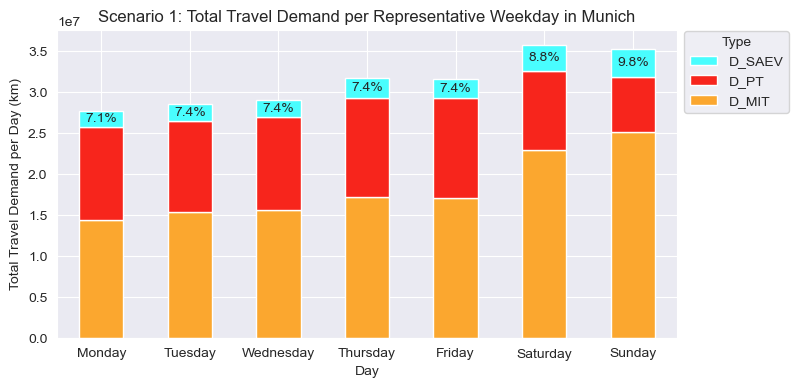

In [28]:
custom_colors = ['#fba72f', '#f7251c', '#49fdfe']

# Plot the data using pandas plot with stacked bars
ax = total_wegkm_day_SAEV.plot(x='day', y=['wegkm_imp_hoch_fac_MIV', 'wegkm_imp_hoch_fac_PT', 'wegkm_saev'], kind='bar', stacked=True, figsize=(8, 4), rot=0, color=custom_colors)

# Set title and labels
ax.set_xlabel('Day')
ax.set_ylabel('Total Travel Demand per Day (km)')
ax.set_title('Scenario 1: Total Travel Demand per Representative Weekday in Munich')

# Customize the legend with new labels
handles, labels = ax.get_legend_handles_labels()
labels = ['D_MIT', 'D_PT', 'D_SAEV']
ax.legend(handles[::-1], labels[::-1], title='Type', bbox_to_anchor=(1, 1.02), loc='upper left')

# The last container corresponds to 'wegkm_saev'
container = ax.containers[-1]
labels = [f'{(v*100):.1f}%' if v != 0 else '' for v in total_wegkm_day_SAEV['d_saev/d_tot']]
ax.bar_label(container, labels=labels, label_type='center')

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(millions))





# Show the plot
plt.tight_layout()
plt.show()

## Scenario 2

In [29]:
# Group dfs_tot_MIT_PT_nohw_hw by 'wegkm_imp_hoch_fac', 'wegkm_imp_hoch_fac_MIV', d_opnv_ae_s, and 'wegkm_saev' by 'ST_WOTAG' and save in a new df
# Initialize an empty DataFrame to collect the results
total_wegkm_day_SAEV = pd.DataFrame()

# Iterate over the dictionary of DataFrames
for day, df in dfs_interpolated.items():
    # Sum the specified columns for each day DataFrame
    day_sum = df[['wegkm_imp_hoch_fac', 'wegkm_imp_hoch_fac_MIV', 'd_opnv_ae_s', 'wegkm_saev']].sum().to_frame().T
    
    # Add the day information (could be an index or a column as needed)
    day_sum['day'] = day
    
    # Append the summed DataFrame to the results
    total_wegkm_day_SAEV = pd.concat([total_wegkm_day_SAEV, day_sum], ignore_index=True)
    
total_wegkm_day_SAEV['d_saev/d_miv'] = total_wegkm_day_SAEV['wegkm_saev'] / total_wegkm_day_SAEV['wegkm_imp_hoch_fac_MIV']
total_wegkm_day_SAEV['d_saev/d_tot'] = total_wegkm_day_SAEV['wegkm_saev'] / total_wegkm_day_SAEV['wegkm_imp_hoch_fac']

# Save only the data that was plotted in a new DataFrame called total_wegkm_day_Scenario2 and rename the column in the same line
total_wegkm_day_Scenario2 = total_wegkm_day_SAEV[['day', 'wegkm_imp_hoch_fac_MIV', 'd_opnv_ae_s', 'wegkm_saev', 'd_saev/d_tot']].rename(columns={'wegkm_imp_hoch_fac_MIV': 'd_mit_ae_s'}).copy()



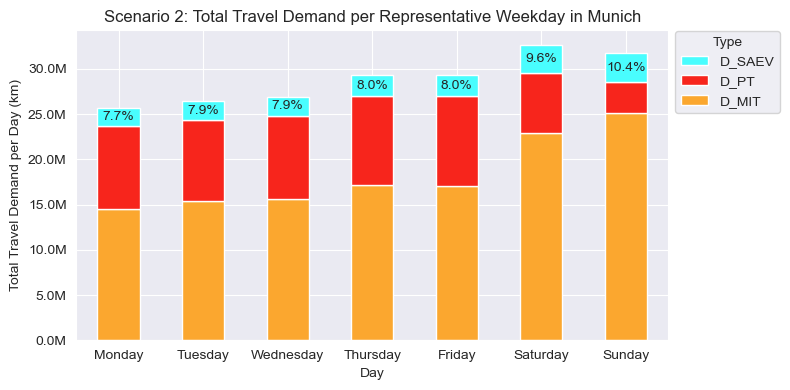

In [32]:
custom_colors = ['#fba72f', '#f7251c', '#49fdfe']

# Plot the data using pandas plot with stacked bars
ax = total_wegkm_day_SAEV.plot(x='day', y=['wegkm_imp_hoch_fac_MIV', 'd_opnv_ae_s', 'wegkm_saev'], kind='bar', stacked=True, figsize=(8, 4), rot=0, color=custom_colors)

# Set title and labels
ax.set_xlabel('Day')
ax.set_ylabel('Total Travel Demand per Day (km)')
ax.set_title('Scenario 2: Total Travel Demand per Representative Weekday in Munich')

# Customize the legend with new labels
handles, labels = ax.get_legend_handles_labels()
labels = ['D_MIT', 'D_PT', 'D_SAEV']
ax.legend(handles[::-1], labels[::-1], title='Type', bbox_to_anchor=(1, 1.02), loc='upper left')

# The last container corresponds to 'wegkm_saev'
container = ax.containers[-1]
labels = [f'{(v*100):.1f}%' if v != 0 else '' for v in total_wegkm_day_SAEV['d_saev/d_tot']]
ax.bar_label(container, labels=labels, label_type='center')

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(millions))


# Show the plot
plt.tight_layout()
plt.show()

In [33]:
# Initialize an empty DataFrame to store the cumulative sum across all days
week_sum_df = pd.DataFrame()

# Iterate over the dictionary of DataFrames
for day, df in dfs_interpolated.items():
    if week_sum_df.empty:
        # If week_sum_df is empty, initialize it with the current DataFrame
        week_sum_df = df.copy()
    else:
        # Add the current day's DataFrame to the cumulative sum DataFrame
        week_sum_df = week_sum_df.add(df, fill_value=0)



# Sum each column
week_column_sum_df = week_sum_df.sum(axis=0).to_frame().T



## Scenario 3

In [34]:
# Calculate a new column for all dfs in the dictionary that is called wegkm_saev and calculated by d_miv_ae_s - wegkm_imp_hoch_fac_MIV
for day, df in dfs_interpolated.items():
    df['wegkm_saev'] = df['d_miv_ae_s'] - df['wegkm_imp_hoch_fac_MIV']
    df['d_mit_ae_s'] =  df['wegkm_imp_hoch_fac_MIV'] - df['wegkm_saev']
    

In [35]:
# Group dfs_tot_MIT_PT_nohw_hw by 'wegkm_imp_hoch_fac', 'wegkm_imp_hoch_fac_MIV', d_opnv_ae_s, and 'wegkm_saev' by 'ST_WOTAG' and save in a new df
# Initialize an empty DataFrame to collect the results
total_wegkm_day_SAEV = pd.DataFrame()

# Iterate over the dictionary of DataFrames
for day, df in dfs_interpolated.items():
    # Sum the specified columns for each day DataFrame
    day_sum = df[['wegkm_imp_hoch_fac', 'd_mit_ae_s', 'wegkm_imp_hoch_fac_PT', 'wegkm_saev']].sum().to_frame().T
    
    # Add the day information (could be an index or a column as needed)
    day_sum['day'] = day
    
    # Append the summed DataFrame to the results
    total_wegkm_day_SAEV = pd.concat([total_wegkm_day_SAEV, day_sum], ignore_index=True)
    
#total_wegkm_day_SAEV['d_saev/d_miv'] = total_wegkm_day_SAEV['wegkm_saev'] / total_wegkm_day_SAEV['wegkm_imp_hoch_fac_MIV']
total_wegkm_day_SAEV['d_saev/d_tot'] = total_wegkm_day_SAEV['wegkm_saev'] / total_wegkm_day_SAEV['wegkm_imp_hoch_fac']

# Save only the data that was plotted in a new DataFrame called total_wegkm_day_Scenario3 and rename the column in the same line
total_wegkm_day_Scenario3 = total_wegkm_day_SAEV[['day', 'd_mit_ae_s', 'wegkm_imp_hoch_fac_PT', 'wegkm_saev', 'd_saev/d_tot']].rename(columns={'wegkm_imp_hoch_fac_PT': 'd_opnv_ae_s'}).copy()



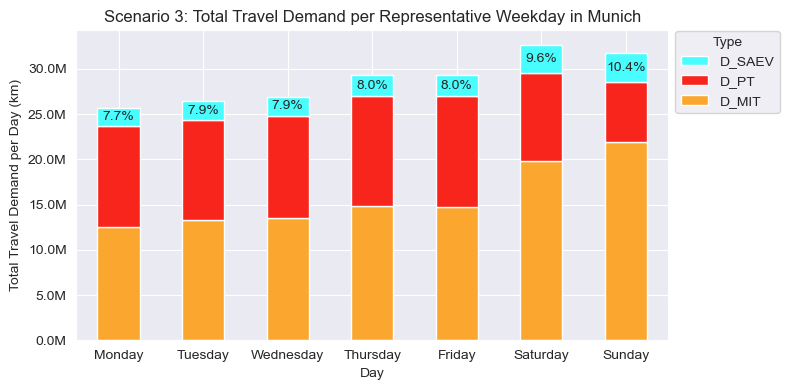

In [36]:
custom_colors = ['#fba72f', '#f7251c', '#49fdfe']

# Plot the data using pandas plot with stacked bars
ax = total_wegkm_day_SAEV.plot(x='day', y=['d_mit_ae_s', 'wegkm_imp_hoch_fac_PT', 'wegkm_saev'], kind='bar', stacked=True, figsize=(8, 4), rot=0, color=custom_colors)

# Set title and labels
ax.set_xlabel('Day')
ax.set_ylabel('Total Travel Demand per Day (km)')
ax.set_title('Scenario 3: Total Travel Demand per Representative Weekday in Munich')

# Customize the legend with new labels
handles, labels = ax.get_legend_handles_labels()
labels = ['D_MIT', 'D_PT', 'D_SAEV']
ax.legend(handles[::-1], labels[::-1], title='Type', bbox_to_anchor=(1, 1.02), loc='upper left')

# The last container corresponds to 'wegkm_saev'
container = ax.containers[-1]
labels = [f'{(v*100):.1f}%' if v != 0 else '' for v in total_wegkm_day_SAEV['d_saev/d_tot']]
ax.bar_label(container, labels=labels, label_type='center')

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(millions))



# Show the plot
plt.tight_layout()
plt.show()

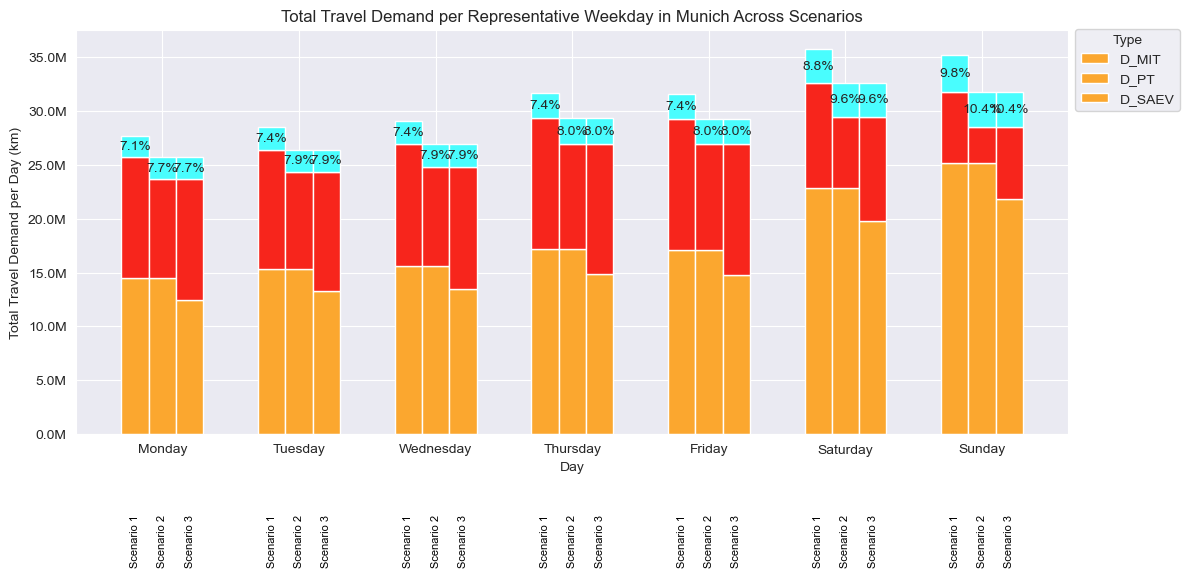

In [37]:
# Custom colors for the types
custom_colors = ['#fba72f', '#f7251c', '#49fdfe']  # Colors for D_MIT, D_PT, D_SAEV

# Assuming you have the data in DataFrames
# total_wegkm_day_Scenario1, total_wegkm_day_Scenario2, total_wegkm_day_Scenario3

# Add a 'Scenario' column to each DataFrame to distinguish between the scenarios
total_wegkm_day_Scenario1['Scenario'] = 'Scenario 1'
total_wegkm_day_Scenario2['Scenario'] = 'Scenario 2'
total_wegkm_day_Scenario3['Scenario'] = 'Scenario 3'

# Combine the DataFrames
combined_df = pd.concat([total_wegkm_day_Scenario1, total_wegkm_day_Scenario2, total_wegkm_day_Scenario3])

# Ensure 'day' is treated as a categorical variable to control the order
combined_df['day'] = pd.Categorical(combined_df['day'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

# Sort by 'day' and 'Scenario' to ensure correct plotting order
combined_df = combined_df.sort_values(['day', 'Scenario'])

# Create a pivot table for plotting
pivot_df = combined_df.pivot_table(index='day', columns='Scenario', values=['d_mit_ae_s', 'd_opnv_ae_s', 'wegkm_saev', 'd_saev/d_tot'])

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of each bar
bar_width = 0.2

# Set the positions of the bars on the x-axis
positions = np.arange(len(pivot_df))

# Plot the data for each scenario
for i, scenario in enumerate(pivot_df.columns.levels[1]):
    scenario_data = pivot_df.xs(scenario, level='Scenario', axis=1)
    bars_mit = ax.bar(positions + i * bar_width, scenario_data['d_mit_ae_s'], bar_width, label=f'Scenario {i+1}', color=custom_colors[0])
    bars_opnv = ax.bar(positions + i * bar_width, scenario_data['d_opnv_ae_s'], bar_width, bottom=scenario_data['d_mit_ae_s'], color=custom_colors[1])
    bars_saev = ax.bar(positions + i * bar_width, scenario_data['wegkm_saev'], bar_width, bottom=scenario_data['d_mit_ae_s'] + scenario_data['d_opnv_ae_s'], color=custom_colors[2])

    # Add labels below the bars indicating the scenario
    for bar in bars_saev:
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            -0.2,  # Adjust this value for positioning below the x-axis
            f'Scenario {i+1}', 
            ha='center', 
            va='top', 
            fontsize=8, 
            rotation = 90,
            color='black', 
            transform=ax.get_xaxis_transform()  # Ensures the text is positioned relative to the x-axis
        )

# Add percentage labels for 'wegkm_saev' for each scenario explicitly
# Scenario 1
container_scenario_1 = ax.containers[2]  # The container for Scenario 1 'wegkm_saev' bars
labels_scenario_1 = [f'{(v * 100):.1f}%' if v != 0 else '' for v in pivot_df[('d_saev/d_tot', 'Scenario 1')]]
ax.bar_label(container_scenario_1, labels=labels_scenario_1, label_type='center')

# Scenario 2
container_scenario_2 = ax.containers[5]  # The container for Scenario 2 'wegkm_saev' bars
labels_scenario_2 = [f'{(v * 100):.1f}%' if v != 0 else '' for v in pivot_df[('d_saev/d_tot', 'Scenario 2')]]
ax.bar_label(container_scenario_2, labels=labels_scenario_2, label_type='center')

# Scenario 3
container_scenario_3 = ax.containers[8]  # The container for Scenario 3 'wegkm_saev' bars
labels_scenario_3 = [f'{(v * 100):.1f}%' if v != 0 else '' for v in pivot_df[('d_saev/d_tot', 'Scenario 3')]]
ax.bar_label(container_scenario_3, labels=labels_scenario_3, label_type='center')

# Set x-axis labels
ax.set_xticks(positions + bar_width)
ax.set_xticklabels(pivot_df.index)

# Set title and labels
ax.set_xlabel('Day')
ax.set_ylabel('Total Travel Demand per Day (km)')
ax.set_title('Total Travel Demand per Representative Weekday in Munich Across Scenarios')

# Customize the legend with new labels
handles, labels = ax.get_legend_handles_labels()
labels = ['D_SAEV', 'D_PT', 'D_MIT']
ax.legend(handles[::-1], labels[::-1], title='Type', bbox_to_anchor=(1, 1.02), loc='upper left')

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Apply tight layout
plt.tight_layout()


# Show the plot
plt.show()

In [ ]:
# Compute total travel demand per week for each mode across all scenarios
total_demand_week = pd.DataFrame({
    'MT': [pivot_df[('d_mit_ae_s', 'Scenario 1')].sum(), pivot_df[('d_mit_ae_s', 'Scenario 2')].sum(), pivot_df[('d_mit_ae_s', 'Scenario 3')].sum()],
    'PT': [pivot_df[('d_opnv_ae_s', 'Scenario 1')].sum(), pivot_df[('d_opnv_ae_s', 'Scenario 2')].sum(), pivot_df[('d_opnv_ae_s', 'Scenario 3')].sum()],
    'SAEV': [pivot_df[('wegkm_saev', 'Scenario 1')].sum(), pivot_df[('wegkm_saev', 'Scenario 2')].sum(), pivot_df[('wegkm_saev', 'Scenario 3')].sum()]
}, index=['Scenario 1', 'Scenario 2', 'Scenario 3'])

# Baseline data: Calculate the total baseline travel demand per week for each mode
baseline_demand = {
    'MT': daily_totals['wegkm_imp_hoch_fac_MIV'].sum(),  # Total demand over the whole week for MT
    'PT': daily_totals['wegkm_imp_hoch_fac_PT'].sum(),  # Total demand over the whole week for PT
    'SAEV': 0  # Assuming no baseline value for SAEV
}

# Add baseline data as a separate DataFrame
baseline_df_demand = pd.DataFrame({
    'MT': [baseline_demand['MT']],
    'PT': [baseline_demand['PT']],
    'SAEV': [baseline_demand['SAEV']]
}, index=['Baseline'])

# Calculate the total baseline for the horizontal line
total_baseline_demand = baseline_df_demand.sum(axis=1).values[0]

# Concatenate baseline data with scenario data
combined_data_demand = pd.concat([baseline_df_demand, total_demand_week])

# Custom colors for the bars to match the original plot colors
bar_colors_demand = ['#fba72f', '#f7251c', '#49fdfe']  # MT, PT, SAEV

# Plotting the stacked bar chart for travel demand
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each mode as a stacked bar with cyan outline for SAEV
combined_data_demand[['MT', 'PT', 'SAEV']].plot(
    kind='bar', 
    stacked=True, 
    color=bar_colors_demand, 
    ax=ax, 
    edgecolor=['black', 'black', 'black']  # Cyan outline for SAEV
)

# Draw a single horizontal dotted line for the total baseline
ax.axhline(total_baseline_demand, color='black', linestyle='--', linewidth=1, label='Total Baseline')

# Add percentage labels for 'SAEV' for each scenario explicitly
for i, scenario in enumerate(combined_data_demand.index):
    if combined_data_demand['SAEV'][i] > 0:  # Only add labels for non-zero SAEV values
        saev_percent = (combined_data_demand['SAEV'][i] / combined_data_demand.loc[scenario].sum()) * 100
        ax.text(i, combined_data_demand.loc[scenario].sum() - combined_data_demand['SAEV'][i] / 2, 
                f'{saev_percent:.1f}%', ha='center', va='center', fontsize=10, color='black')

# Set labels and title
ax.set_xlabel('Scenario')
ax.set_ylabel('Total Travel Demand per Week (km)')
ax.set_title('Total Travel Demand per Week for Different Modes Across Scenarios and Baseline')

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Customize the legend
ax.legend(title='Transport Mode', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

# Show plot
plt.show()

# Emission Model

In [39]:
# Specify path for EmissionDatav2.xlsx
# params_path = 

params_df = pd.read_excel(params_path, sheet_name='Munich')

### Emissions from operations 

In [40]:
# Convert DataFrame to a dictionary for base values
base_values = params_df.set_index('Parameter')['Base value'].to_dict()
e_Conv_Bus = base_values['E_Conv_Bus']   # Emission factor conventional bus per km [kg/km]
e_MIV = 0.166
e_MIV2 = (base_values['Proportion_Gasoline'] * base_values['Consumption_Gasoline'] * base_values['Emissionfactor_Gasoline'] + base_values['Proportion_Diesel'] * base_values['Consumption_Diesel'] * base_values['Emissionfactor_Diesel'] + base_values['Proportion_BEV'] * base_values['Consumption_BEV'] * base_values['Emissionfactor_BEV_conv'] )/base_values['Occupancy_Rate_conv']
e_AEV_conv = base_values['Consumption_BEV'] * base_values['Emissionfactor_BEV_conv'] / base_values['Occupancy_Rate_AEV']
e_AEV_renew = base_values['Consumption_BEV'] * base_values['Emissionfactor_BEV_renew'] / base_values['Occupancy_Rate_AEV']
e_SAEV = (base_values['Consumption_BEV'] * base_values['Emissionfactor_BEV_renew'] )/ base_values['Occupancy_Rate_SAEV']


In [41]:
# Function to calculate D_MIV_neu, D_OPNV_neu, and D_MIV_AE_S based on conditions
def calculate_emissions(row):
    E_MIV_1 = row ['wegkm_imp_hoch_fac_MIV'] * e_MIV /1000
    E_OPNV_1 = row ['wegkm_imp_hoch_fac_PT'] * e_Conv_Bus /1000
    return pd.Series([E_MIV_1, E_OPNV_1])

for day, df in dfs_tot_MIT_PT_nohw_hw.items():
# Apply the function to each row
    df[['E_MIV_1', 'E_OPNV_1']] = df.apply(calculate_emissions, axis=1)



In [42]:
# Function to calculate D_MIV_neu, D_OPNV_neu, and D_MIV_AE_S based on conditions
def calculate_emissions_SAEV(row):
    E_SAEV_2 = row['wegkm_saev'] * e_SAEV/1000
    E_AEV_2 = row['wegkm_saev'] * e_AEV_conv/1000
    E_MIV_2 = row ['d_mit_ae_s'] * e_MIV/1000
    E_OPNV_2 = row ['d_opnv_ae_s'] * e_Conv_Bus/1000
    return pd.Series([E_SAEV_2,E_AEV_2, E_MIV_2, E_OPNV_2])


# Apply the function to calculate emissions for each row and update specific columns
for column in combined_df.columns:
    combined_df[['E_SAEV_2', 'E_AEV_2', 'E_MIV_2', 'E_OPNV_2']] = combined_df.apply(calculate_emissions_SAEV, axis=1)


In [43]:
# Initialize lists to hold the cumulative integrals and day labels across all days

cumulative_MIV_1 = []
cumulative_OPNV_1 = []
cumulative_sum_1 = []

day_labels = []

# Initialize variables to accumulate the cumulative sum over days
total_integral_MIV_1 = 0.0
total_integral_OPNV_1 = 0.0

# Custom colors for the lines and shaded areas
line_colors = ['#49fdfe', '#f7251c', '#fba72f']  # Colors for D_SAEV, D_PT, D_MIT
area_colors = ['#b3e5fc', '#f8bbd0', '#ffe0b2']  # Lighter shades for the areas
total_line_color = '#0000FF'  # Color for the total line
total_area_color = '#add8e6'  # Lighter shade for the total area

# Create a pivot table for plotting
pivot_df = combined_df.pivot_table(index='day', columns='Scenario', values=['E_SAEV_2', 'E_MIV_2', 'E_OPNV_2'])

# Calculate the total demand for each scenario
pivot_df['total', 'Scenario 1'] = pivot_df[('E_MIV_2', 'Scenario 1')] + pivot_df[('E_OPNV_2', 'Scenario 1')] + pivot_df[('E_SAEV_2', 'Scenario 1')]
pivot_df['total', 'Scenario 2'] = pivot_df[('E_MIV_2', 'Scenario 2')] + pivot_df[('E_OPNV_2', 'Scenario 2')] + pivot_df[('E_SAEV_2', 'Scenario 2')]
pivot_df['total', 'Scenario 3'] = pivot_df[('E_MIV_2', 'Scenario 3')] + pivot_df[('E_OPNV_2', 'Scenario 3')] + pivot_df[('E_SAEV_2', 'Scenario 3')]

# Compute the cumulative sum for each scenario
for scenario in ['Scenario 1', 'Scenario 2', 'Scenario 3']:
    pivot_df[('cumulative_E_mit', scenario)] = pivot_df[('E_MIV_2', scenario)].cumsum()
    pivot_df[('cumulative_E_opnv', scenario)] = pivot_df[('E_OPNV_2', scenario)].cumsum()
    pivot_df[('cumulative_E_saev', scenario)] = pivot_df[('E_SAEV_2', scenario)].cumsum()
    pivot_df[('cumulative_total', scenario)] = pivot_df[('total', scenario)].cumsum()


# Iterate over each day to compute the cumulative integrals
for day, df in dfs_tot_MIT_PT_nohw_hw.items():
    # Ensure that the DataFrame is sorted by index (time) to correctly apply the trapezoidal rule
    df = df.sort_index()
    # Fill NaN values with zeroes
    df['E_MIV_1'].fillna(0, inplace=True)
    df['E_OPNV_1'].fillna(0, inplace=True)


    integral_MIV_1 = np.trapz(df['E_MIV_1'].values, dx=1)
    total_integral_MIV_1 += integral_MIV_1
    cumulative_MIV_1.append(total_integral_MIV_1)

    integral_OPNV_1 = np.trapz(df['E_OPNV_1'].values, dx=1)
    total_integral_OPNV_1 += integral_OPNV_1
    cumulative_OPNV_1.append(total_integral_OPNV_1)

    # Store the day labels for x-axis
    day_labels.append(day)


# Calculate the cumulative sums
for i in range(len(cumulative_MIV_1)):
    sum_1 = cumulative_MIV_1[i] + cumulative_OPNV_1[i]
    cumulative_sum_1.append(sum_1)



In [44]:
# Compute the total emissions per week for each mode across all scenarios
total_emissions_week = pd.DataFrame({
    'MT': [pivot_df[('E_MIV_2', 'Scenario 1')].sum(), pivot_df[('E_MIV_2', 'Scenario 2')].sum(), pivot_df[('E_MIV_2', 'Scenario 3')].sum()],
    'PT': [pivot_df[('E_OPNV_2', 'Scenario 1')].sum(), pivot_df[('E_OPNV_2', 'Scenario 2')].sum(), pivot_df[('E_OPNV_2', 'Scenario 3')].sum()],
    'SAEV': [pivot_df[('E_SAEV_2', 'Scenario 1')].sum(), pivot_df[('E_SAEV_2', 'Scenario 2')].sum(), pivot_df[('E_SAEV_2', 'Scenario 3')].sum()],
    'Total': [
        pivot_df[('total', 'Scenario 1')].sum(),
        pivot_df[('total', 'Scenario 2')].sum(),
        pivot_df[('total', 'Scenario 3')].sum()
    ],
    'Scenario': ['Scenario 1', 'Scenario 2', 'Scenario 3']
})

# Baseline data: Calculate the total baseline emissions per week for each mode
baseline_data = {
    'MT': cumulative_MIV_1[-1],  # Total emissions over the whole week for MT
    'PT': cumulative_OPNV_1[-1],  # Total emissions over the whole week for PT
    'SAEV': 0,  # Assuming no baseline value for SAEV, set to 0 or another relevant value
    'Total': cumulative_sum_1[-1]  # Total emissions over the whole week for all modes
}




In [45]:
# Compute total emissions per week for each mode across all scenarios
total_emissions_week = pd.DataFrame({
    'MT': [pivot_df[('E_MIV_2', 'Scenario 1')].sum(), pivot_df[('E_MIV_2', 'Scenario 2')].sum(), pivot_df[('E_MIV_2', 'Scenario 3')].sum()],
    'PT': [pivot_df[('E_OPNV_2', 'Scenario 1')].sum(), pivot_df[('E_OPNV_2', 'Scenario 2')].sum(), pivot_df[('E_OPNV_2', 'Scenario 3')].sum()],
    'SAEV': [pivot_df[('E_SAEV_2', 'Scenario 1')].sum(), pivot_df[('E_SAEV_2', 'Scenario 2')].sum(), pivot_df[('E_SAEV_2', 'Scenario 3')].sum()]
}, index=['Scenario 1', 'Scenario 2', 'Scenario 3'])

# Baseline data: Calculate the total baseline emissions per week for each mode
baseline_data = {
    'MT': cumulative_MIV_1[-1],  # Total emissions over the whole week for MT
    'PT': cumulative_OPNV_1[-1],  # Total emissions over the whole week for PT
    'SAEV': 0  # Assuming no baseline value for SAEV, set to 0 or another relevant value
}

# Add baseline data as a separate DataFrame
baseline_df = pd.DataFrame({
    'MT': [baseline_data['MT']],
    'PT': [baseline_data['PT']],
    'SAEV': [baseline_data['SAEV']]
}, index=['Baseline'])

# Calculate the total baseline for the horizontal line
total_baseline = baseline_df.sum(axis=1).values[0]

# Concatenate baseline data with scenario data
combined_data = pd.concat([baseline_df, total_emissions_week])



In [46]:
# Baseline total emissions
baseline_total_emissions = baseline_df.sum(axis=1).values[0]

# Total emissions for each scenario
scenario_totals = total_emissions_week.sum(axis=1)

# Calculate the relative change from the baseline to each scenario
relative_changes = ((scenario_totals - baseline_total_emissions) / baseline_total_emissions) * 100

# Create a DataFrame to display the relative changes
relative_changes_df = pd.DataFrame({
    'Scenario': ['Scenario 1', 'Scenario 2', 'Scenario 3'],
    'Relative Change (%)': relative_changes.values
})


### Emissions from production and End-of-life
#### Fleet size: 
Li et al:
We examine three different assumptions for the growth of the SAEV fleet based on different proportions of current Uber and Lyft market size, which is around 96,000 vehicles in the San Francisco Bay Area of California. Under medium adoption level, the SAEV fleet will be as large as 10% of current TNC market by 2030. And the low and high adoption levels correspond to 5% and 25% respectively. We assume a linear growth in the market adoption from 0% in 2021 to 2030.

For the remaining part of the Results section, one scenario was analyzed in more detail. The 10% demand–10% fleet scenario was chosen as an example because it combines a large demand with a small fleet, which introduces competition for AVs in the scenario (Bösch Paper)


In [47]:
# Extract individual values from the dictionary
Fleetsize = base_values['Fleet_Munich']   # Emission factor conventional bus per km [t/km]

#Scanrio builder
Fleetproportion = 0.1
Private_Vehicle_Replacement_Rate = 4
Fleetsize_SAEV = round(Fleetproportion * Fleetsize)
Fleetsize_private =round( Fleetsize- (Fleetsize_SAEV/Private_Vehicle_Replacement_Rate))



In [60]:
# Load excel file
# Specify path for EmissionDatav2.xlsx
#params_path =

params_df = pd.read_excel(params_path, sheet_name='VehMun')  

emission_df = params_df.drop(params_df.columns[8:13], axis=1)  # Spaltenindex 8 entspricht Spalte I, und 13 entspricht Spalte M

emission_df = emission_df.iloc[[1, 2, 9, 9,11]]

emission_df.loc[1, 'Modell'] = 'E_Conv_Car_Gasoline'
emission_df.loc[2, 'Modell'] = 'E_Conv_Car_Diesel'
# Rename the first occurrence of row with index 9 in the 'Modell' column 
emission_df.iloc[emission_df.index.get_indexer_for([9])[0], emission_df.columns.get_loc('Modell')] = 'E_EA_PooledTaxi/Ind.Taxi'
# Rename the second occurrence of row with index 9 in the 'Modell' column 
emission_df.iloc[emission_df.index.get_indexer_for([9])[1], emission_df.columns.get_loc('Modell')] = 'E_Conv_Car_BEV'
emission_df.loc[11, 'Modell'] = 'E_Conv_Bus'

# Platzieren der neuen Spalte 'Modell' ganz vorne im DataFrame
emission_df = emission_df[['Modell'] + [col for col in emission_df.columns if col != 'Modell']]

# Konvertieren der Spalte 'Curb Weight (kg)' in numerische Werte (float)
emission_df['Curb Weight (kg)'] = pd.to_numeric(emission_df['Curb Weight (kg)'], errors='coerce')

# Variable für Produktionsemissionen
production_emissions_vehicle_body = 4.56 #kg CO2 − eq.∕kg
production_emissions_battery_pack = 83.50 #kg CO2 − eq.∕kWh

#Variable for Recyling emission
recycling_emissions_vehicle_body = 2.93#kg CO2 − eq.∕kg
recycling_emissions_battery_pack = 48.4 #kg CO2 − eq.∕kWh


# Multipliziere die Spalte 'Curb Weight (kg)' mit der Variable 'production_emissions_vehicle_body'
emission_df['Production Emissions (kg Co2 Eq)'] = emission_df['Curb Weight (kg)'] * production_emissions_vehicle_body + emission_df['Battery Gross Capacity (kWh)'] * production_emissions_battery_pack

# Multipliziere die Spalte 'Curb Weight (kg)' mit der Variable 'recycling_emissions_vehicle_body'
emission_df['Recycling Emissions (kg Co2 Eq)'] = -(emission_df['Curb Weight (kg)'] * recycling_emissions_vehicle_body) - (emission_df['Battery Gross Capacity (kWh)'] * recycling_emissions_battery_pack)

# Am Ende alle Spalten außer der ersten und letzten löschen
emission_df = emission_df.iloc[:, [0, -1, -2]]



#### Emissions from production

In [50]:
lifetime = 15.7 # Buberger
ProportionDiesel = 0.29
ProportionBenzin = 0.62
ProportionBEV = 0.09
# https://www.kba.de/DE/Statistik/Fahrzeuge/Bestand/Jahrebilanz_Bestand/fz_b_jahresbilanz_node.html#:~:text=Mit%2049.098.685%20Einheiten%20und,8%20%25)%20die%20h%C3%A4ufigsten%20Kraftstoffarten.

production_emissions_afterSAEV = Fleetsize_SAEV * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_EA_PooledTaxi/Ind.Taxi', 'Production Emissions (kg Co2 Eq)'].values[0]) + Fleetsize_private * (ProportionDiesel  * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_Diesel', 'Production Emissions (kg Co2 Eq)'].values[0]) + ProportionBenzin * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_Gasoline', 'Production Emissions (kg Co2 Eq)'].values[0]) + ProportionBEV * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_BEV', 'Production Emissions (kg Co2 Eq)'].values[0]))

production_emissions_preSAEV = Fleetsize * (ProportionDiesel  * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_Diesel', 'Production Emissions (kg Co2 Eq)'].values[0]) + ProportionBenzin * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_Gasoline', 'Production Emissions (kg Co2 Eq)'].values[0]) + ProportionBEV * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_BEV', 'Production Emissions (kg Co2 Eq)'].values[0]))

production_emissions_savings =  production_emissions_afterSAEV - production_emissions_preSAEV



#### Emissions from End-of-life

In [51]:
recycling_emissions_afterSAEV = Fleetsize_SAEV * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_EA_PooledTaxi/Ind.Taxi', 'Recycling Emissions (kg Co2 Eq)'].values[0]) + Fleetsize_private * (ProportionDiesel  * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_Diesel', 'Recycling Emissions (kg Co2 Eq)'].values[0]) + ProportionBenzin * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_Gasoline', 'Recycling Emissions (kg Co2 Eq)'].values[0]) + ProportionBEV * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_BEV', 'Recycling Emissions (kg Co2 Eq)'].values[0]))

recycling_emissions_preSAEV = Fleetsize * (ProportionDiesel  * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_Diesel', 'Recycling Emissions (kg Co2 Eq)'].values[0]) + ProportionBenzin * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_Gasoline', 'Recycling Emissions (kg Co2 Eq)'].values[0]) + ProportionBEV * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_BEV', 'Recycling Emissions (kg Co2 Eq)'].values[0]))

recycling_emissions_savings =   recycling_emissions_afterSAEV - recycling_emissions_preSAEV


### Lifecycle Emissions

#### Scenario 1

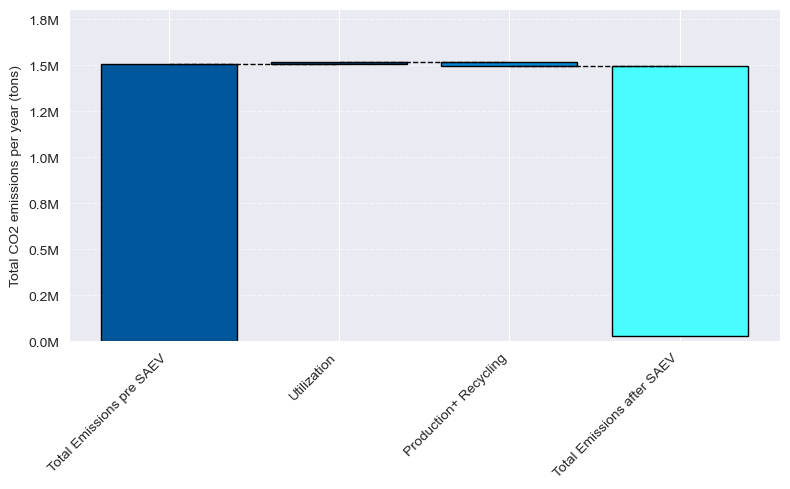

In [52]:
number_of_weeks = 52
# Define the initial total value and the blocks
total_value = (production_emissions_preSAEV/1000)/lifetime  + cumulative_sum_1[-1] * number_of_weeks + (recycling_emissions_preSAEV/1000)/lifetime
# Calculate the blocks for the waterfall
first_block = -(pivot_df[('cumulative_total', 'Scenario 1')].iloc[-1]* number_of_weeks  - cumulative_sum_1[-1] * number_of_weeks )#considers only base case and scenario 1
second_block = (production_emissions_savings/1000)/lifetime + (recycling_emissions_savings/1000)/lifetime
third_block = total_value+first_block-second_block


blocks = [  first_block,second_block,third_block]

# Calculate the cumulative values to create a falling waterfall
cumulative = [total_value]
for block in blocks:
    cumulative.append(cumulative[-1] - block)

# Plotting the waterfall diagram
fig, ax = plt.subplots(figsize=(8, 5))

# Define colors for the bars (similar shades)
colors = ['#01579b', '#0288d1', '#49fdfe']  # Different shades of blue for the blocks

# Plot the initial total bar on the left side
ax.bar(0, total_value, color=colors[0], edgecolor='black', label='Total')

# Plot the waterfall blocks
for i in range(3):
    # Use a darker color for the last bar
    bar_color = colors[i] 


    ax.bar(i + 1, -blocks[i], bottom=cumulative[i], color=bar_color, edgecolor='black')
# Draw lines connecting the bars to create the waterfall effect
for i in range(0, 3):
    ax.plot([i, i + 1], [cumulative[i], cumulative[i]], color='black', linestyle='--', linewidth=1)

# Add labels for the bars
ax.set_xticks(range(4))
ax.set_xticklabels(['Total Emissions pre SAEV', 'Utilization','Production+ Recycling',  'Total Emissions after SAEV'])

# Set title and labels
#ax.set_title('Effect on SAEV emissions')
ax.set_ylabel('Total CO2 emissions per year (tons)')
#ax.set_xlabel('Lifecycle phase')

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Add gridlines
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
# Scale the y-axis higher for better visibility
ax.set_ylim([0, total_value * 1.2])  # Adjust this multiplier as needed

plt.tight_layout()
plt.show()

In [53]:


# Create the DataFrame to calculate and display the values
data = {
    'Description': [
        'Total Emissions pre SAEV (tons)',
        'Operations Reduction (tons)',
        'Production + Recycling Reduction (tons)',
        'Total Emissions after SAEV (tons)',
        'Percentage Reduction from pre SAEV to post SAEV (%)'
    ],
    'Value': [
        total_value,
        first_block,
        second_block,
        #cumulative[-1],
        third_block,
        ((third_block-total_value) / total_value) * 100
    ]
}

# Create the DataFrame
emission_reduction_df = pd.DataFrame(data)

# Display the DataFrame
print(emission_reduction_df)


                                         Description         Value
0                    Total Emissions pre SAEV (tons)  1.505534e+06
1                        Operations Reduction (tons) -1.269750e+04
2            Production + Recycling Reduction (tons)  1.951040e+04
3                  Total Emissions after SAEV (tons)  1.473326e+06
4  Percentage Reduction from pre SAEV to post SAE... -2.139302e+00


#### Scenario 2

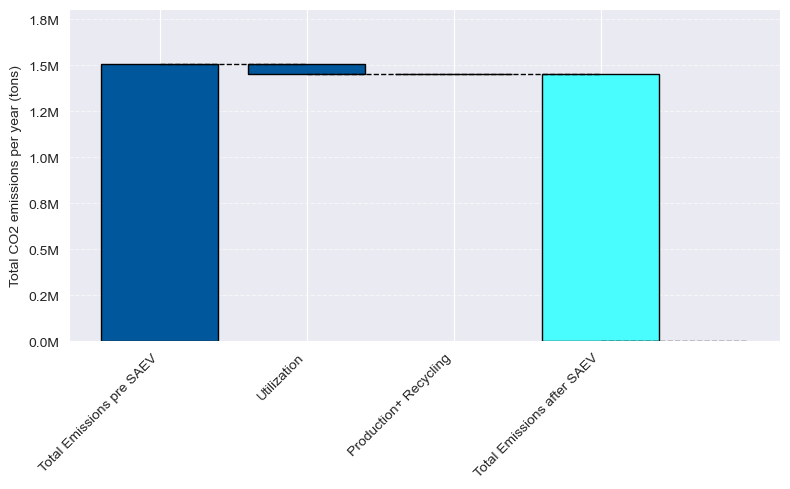

In [54]:
number_of_weeks = 52
# Define the initial total value and the blocks
total_value = (production_emissions_preSAEV/1000)/lifetime  + cumulative_sum_1[-1] * number_of_weeks + (recycling_emissions_preSAEV/1000)/lifetime
# Calculate the blocks for the waterfall
first_block = -(pivot_df[('cumulative_total', 'Scenario 2')].iloc[-1]* number_of_weeks  - cumulative_sum_1[-1] * number_of_weeks )#considers only base case and scenario 1
second_block = 0
third_block =  total_value-first_block-second_block


blocks = [  first_block,second_block,third_block]

# Calculate the cumulative values to create a falling waterfall
cumulative = [total_value]
for block in blocks:
    cumulative.append(cumulative[-1] - block)

# Plotting the waterfall diagram
fig, ax = plt.subplots(figsize=(8, 5))

# Define colors for the bars (similar shades)
colors = ['#01579b', '#0288d1', '#49fdfe']  # Different shades of blue for the blocks

# Plot the initial total bar on the left side
ax.bar(0, total_value, color=colors[0], edgecolor='black', label='Total')

# Plot the waterfall blocks
for i in range(3):
    # Use a darker color for the last bar
    bar_color = colors[i] 


    ax.bar(i + 1, -blocks[i], bottom=cumulative[i], color=bar_color, edgecolor='black')
# Draw lines connecting the bars to create the waterfall effect
for i in range(0, 4):
    ax.plot([i, i + 1], [cumulative[i], cumulative[i]], color='black', linestyle='--', linewidth=1)

# Add labels for the bars
ax.set_xticks(range(4))
ax.set_xticklabels(['Total Emissions pre SAEV',  'Utilization','Production+ Recycling',  'Total Emissions after SAEV'])

# Set title and labels
#ax.set_title('Effect on SAEV emissions')
ax.set_ylabel('Total CO2 emissions per year (tons)')
#ax.set_xlabel('Lifecycle phase')

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Add gridlines
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

# Scale the y-axis higher for better visibility
ax.set_ylim([0, total_value * 1.2])  # Adjust this multiplier as needed
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [55]:

# Create the DataFrame to calculate and display the values
data = {
    'Description': [
        'Total Emissions pre SAEV (tons)',
        'Operations Reduction (tons)',
        'Production + Recycling Reduction (tons)',
        'Total Emissions after SAEV (tons)',
        'Percentage Reduction from pre SAEV to post SAEV (%)'
    ],
    'Value': [
        total_value,
        first_block,
        second_block,
        #cumulative[-1],
        third_block,
        ((third_block-total_value) / total_value) * 100
    ]
}

# Create the DataFrame
emission_reduction_df = pd.DataFrame(data)

# Display the DataFrame
print(emission_reduction_df)

                                         Description         Value
0                    Total Emissions pre SAEV (tons)  1.505534e+06
1                        Operations Reduction (tons)  5.153351e+04
2            Production + Recycling Reduction (tons)  0.000000e+00
3                  Total Emissions after SAEV (tons)  1.454000e+06
4  Percentage Reduction from pre SAEV to post SAE... -3.422939e+00


#### Scenario 3

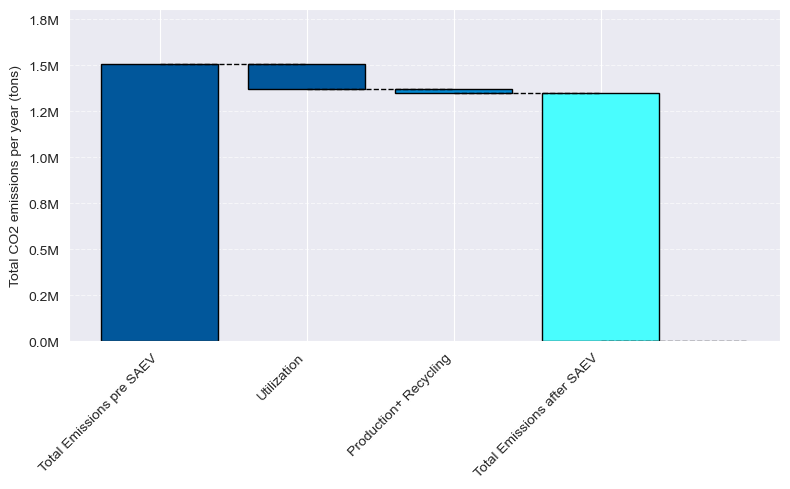

In [56]:
number_of_weeks = 52
# Define the initial total value and the blocks
total_value = (production_emissions_preSAEV/1000)/lifetime  + cumulative_sum_1[-1] * number_of_weeks + (recycling_emissions_preSAEV/1000)/lifetime
# Calculate the blocks for the waterfall
first_block = -(pivot_df[('cumulative_total', 'Scenario 3')].iloc[-1]* number_of_weeks  - cumulative_sum_1[-1] * number_of_weeks )#considers only base case and scenario 1
second_block = (production_emissions_savings/1000)/lifetime + (recycling_emissions_savings/1000)/lifetime
third_block =  total_value-first_block-second_block


blocks = [  first_block,second_block,third_block]

# Calculate the cumulative values to create a falling waterfall
cumulative = [total_value]
for block in blocks:
    cumulative.append(cumulative[-1] - block)

# Plotting the waterfall diagram
fig, ax = plt.subplots(figsize=(8, 5))

# Define colors for the bars (similar shades)
colors = ['#01579b', '#0288d1', '#49fdfe']  # Different shades of blue for the blocks

# Plot the initial total bar on the left side
ax.bar(0, total_value, color=colors[0], edgecolor='black', label='Total')

# Plot the waterfall blocks
for i in range(3):
    # Use a darker color for the last bar
    bar_color = colors[i] 


    ax.bar(i + 1, -blocks[i], bottom=cumulative[i], color=bar_color, edgecolor='black')
# Draw lines connecting the bars to create the waterfall effect
for i in range(0, 4):
    ax.plot([i, i + 1], [cumulative[i], cumulative[i]], color='black', linestyle='--', linewidth=1)

# Add labels for the bars
ax.set_xticks(range(4))
ax.set_xticklabels(['Total Emissions pre SAEV',  'Utilization','Production+ Recycling',  'Total Emissions after SAEV'])

# Set title and labels
#ax.set_title('Effect on SAEV emissions')
ax.set_ylabel('Total CO2 emissions per year (tons)')
#ax.set_xlabel('Lifecycle phase')

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Add gridlines
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

# Scale the y-axis higher for better visibility
ax.set_ylim([0, total_value * 1.2])  # Adjust this multiplier as needed
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()



In [57]:


# Create the DataFrame to calculate and display the values
data = {
    'Description': [
        'Total Emissions pre SAEV (tons)',
        'Operations Reduction (tons)',
        'Production + Recycling Reduction (tons)',
        'Total Emissions after SAEV (tons)',
        'Percentage Reduction from pre SAEV to post SAEV (%)'
    ],
    'Value': [
        total_value,
        first_block,
        second_block,
        #cumulative[-1],
        third_block,
        ((third_block-total_value) / total_value) * 100
    ]
}

# Create the DataFrame
emission_reduction_df = pd.DataFrame(data)